In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression

# Round 4

In [2]:
price_0 = pd.read_csv('../data/raw/round_4/prices_round_4_day_1.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_4/prices_round_4_day_2.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_4/prices_round_4_day_3.csv', delimiter=';')
price_0 = price_0[price_0['product'] == 'MAGNIFICENT_MACARONS']
price_1 = price_1[price_1['product'] == 'MAGNIFICENT_MACARONS']
price_2 = price_2[price_2['product'] == 'MAGNIFICENT_MACARONS']

In [5]:
trades_0 = pd.read_csv('../data/raw/round_4/trades_round_4_day_1.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_4/trades_round_4_day_2.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_4/trades_round_4_day_3.csv', delimiter=';')
trades_0 = trades_0[trades_0['symbol'] == 'MAGNIFICENT_MACARONS']
trades_1 = trades_1[trades_1['symbol'] == 'MAGNIFICENT_MACARONS']
trades_2 = trades_2[trades_2['symbol'] == 'MAGNIFICENT_MACARONS']

In [15]:
obs_0 = pd.read_csv('../data/raw/round_4/observations_round_4_day_1.csv', delimiter=',')
obs_1 = pd.read_csv('../data/raw/round_4/observations_round_4_day_2.csv', delimiter=',')
obs_2 = pd.read_csv('../data/raw/round_4/observations_round_4_day_3.csv', delimiter=',')

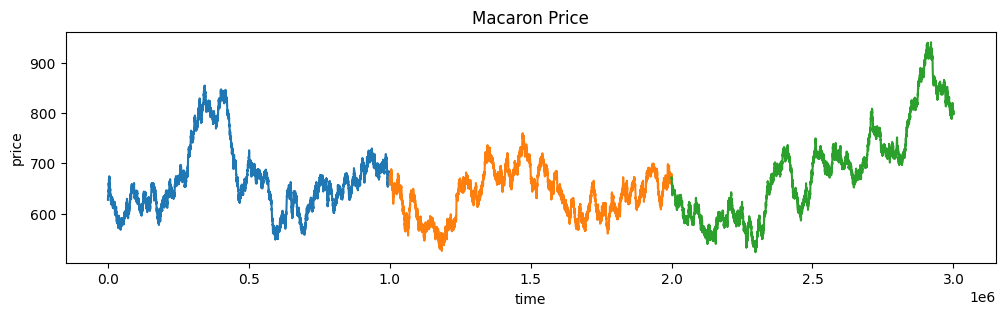

In [12]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Macaron Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [19]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)
observations = pd.concat([obs_0, obs_1, obs_2], axis=0).reset_index(drop=True)

In [24]:
observations

,timestamp,bidPrice,askPrice,transportFees,exportTariff,importTariff,sugarPrice,sunlightIndex
0,0,627.0,628.5,1.0,9.0,-3.0,200.000000,60.00
1,100,630.0,631.5,1.0,9.0,-3.0,200.098445,60.00
2,200,630.0,631.5,1.0,9.0,-3.0,200.103915,60.00
3,300,632.0,633.5,1.0,9.0,-3.0,200.352462,60.01
4,400,630.5,632.0,1.0,9.0,-3.0,200.201545,60.01
...,...,...,...,...,...,...,...,...
29995,999500,797.5,799.0,1.7,9.5,-5.5,212.124918,54.95
29996,999600,801.5,803.0,1.7,9.5,-5.5,212.147650,54.96
29997,999700,804.0,805.5,1.7,9.5,-5.5,212.202086,54.97
29998,999800,798.5,800.0,1.7,9.5,-5.5,212.112734,54.98


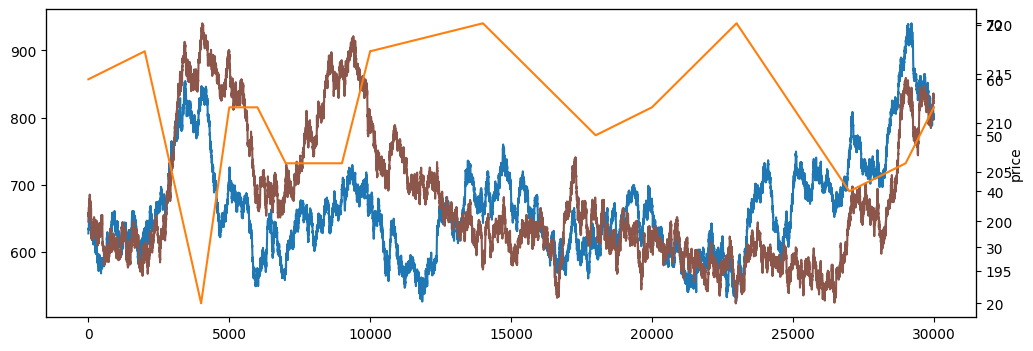

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(prices['mid_price'])
ax2 = ax.twinx()
ax3 = ax.twinx()
ax2.plot(observations['sugarPrice'], c='tab:brown')
ax3.plot(observations['sunlightIndex'], c='tab:orange')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [98]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [99]:
filtered_mid_prices = []
for i in range(prices.shape[0]):
    price = prices.iloc[i]
    bid_prices = price[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
    bid_volumes = price[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].to_numpy()
    bids = dict(zip(bid_prices, bid_volumes))
    ask_prices = price[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
    ask_volumes = price[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].to_numpy()
    asks = dict(zip(ask_prices, ask_volumes))
    
    filtered_asks = [price for price in asks if abs(asks[price]) >= 15]
    filtered_bids = [price for price in bids if abs(bids[price]) >= 15]
    best_filtered_ask = min(filtered_asks) if len(filtered_asks) > 0 else None
    best_filtered_bid = max(filtered_bids) if len(filtered_bids) > 0 else None

    if best_filtered_ask and best_filtered_bid:
        filtered_mid_price = (best_filtered_ask + best_filtered_bid) / 2
    else:
        filtered_mid_price = price['mid_price']
    filtered_mid_prices.append(filtered_mid_price)
prices = prices.assign(filtered_mid_price=filtered_mid_prices)

In [122]:
prices['bid_price_1'].isna().sum(), prices['bid_price_2'].isna().sum(), prices['bid_price_3'].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [123]:
prices['ask_price_1'].isna().sum(), prices['ask_price_2'].isna().sum(), prices['ask_price_3'].isna().sum()

(np.int64(0), np.int64(0), np.int64(0))

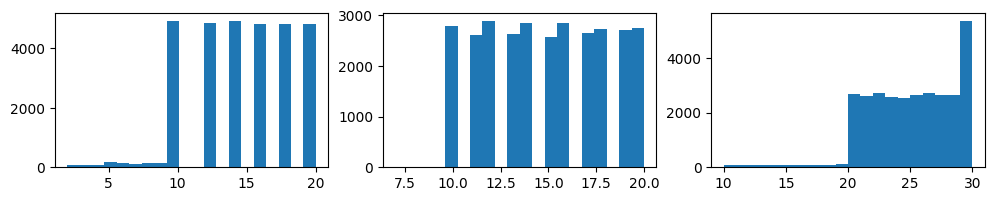

In [222]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['bid_volume_1'], bins=20)
ax[1].hist(prices['bid_volume_2'], bins=20)
ax[2].hist(prices['bid_volume_3'], bins=20)
plt.show()

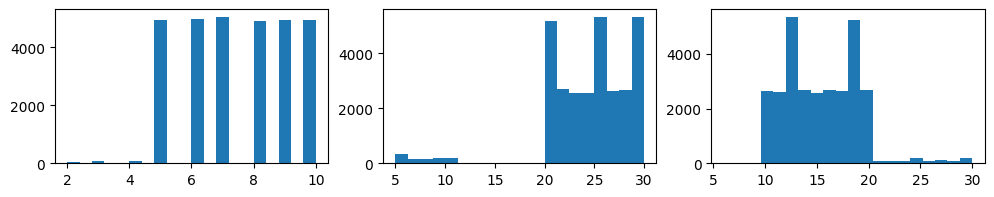

In [223]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
ax[0].hist(prices['ask_volume_1'], bins=20)
ax[1].hist(prices['ask_volume_2'], bins=20)
ax[2].hist(prices['ask_volume_3'], bins=20)
plt.show()

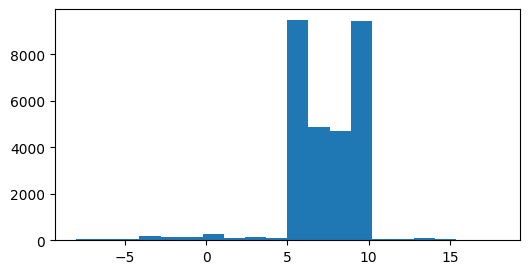

In [103]:
plt.figure(figsize=(6, 3))
plt.hist(prices['bid_volume_1'] - prices['ask_volume_1'], bins=20)
plt.show()

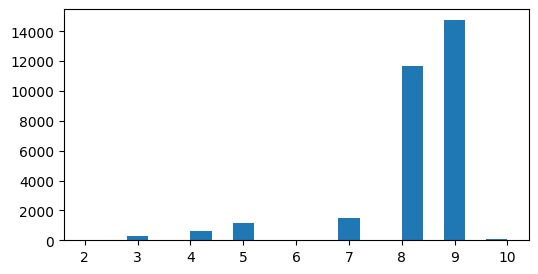

In [104]:
plt.figure(figsize=(6, 3))
plt.hist(prices['ask_price_1'] - prices['bid_price_1'], bins=20)
plt.show()

<Axes: >

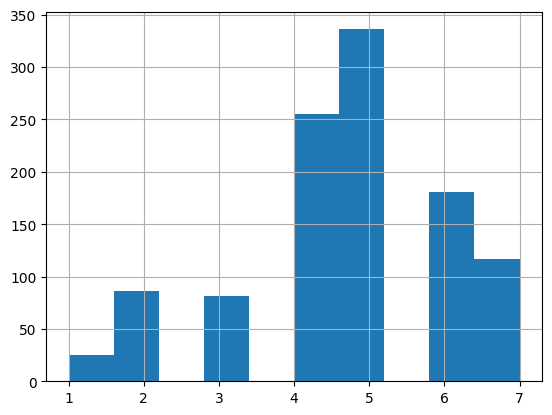

In [227]:
trades['quantity'].hist()

In [110]:
price = prices.iloc[1000:1010]

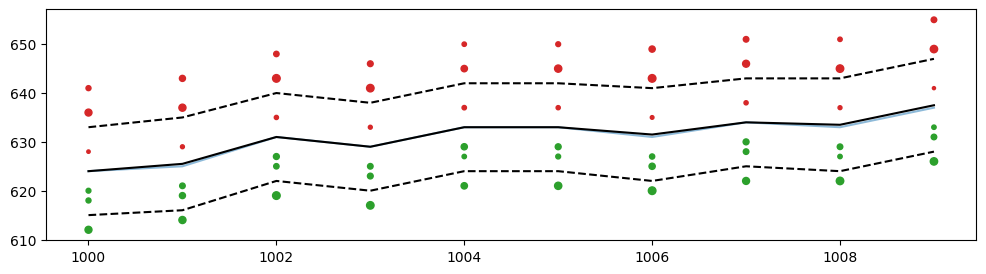

In [113]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 9, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 9, c='k', linestyle='dashed')
plt.show()

In [130]:
(observations['bidPrice'] + observations['askPrice']) / 2

0        627.75
1        630.75
2        630.75
3        632.75
4        631.25
          ...  
29995    798.25
29996    802.25
29997    804.75
29998    799.25
29999    797.75
Length: 30000, dtype: float64

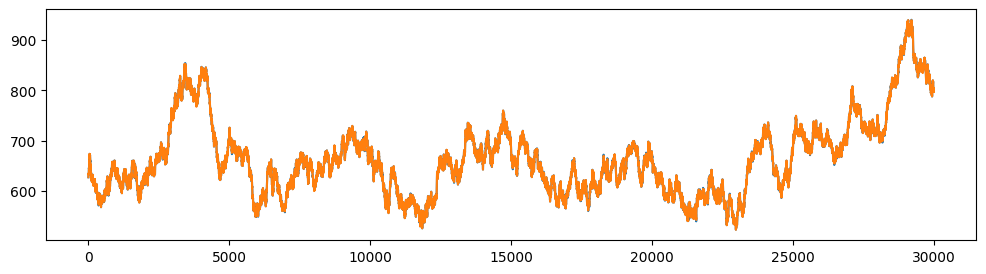

In [133]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
plt.plot((observations['bidPrice'] + observations['askPrice']) / 2)
plt.show()

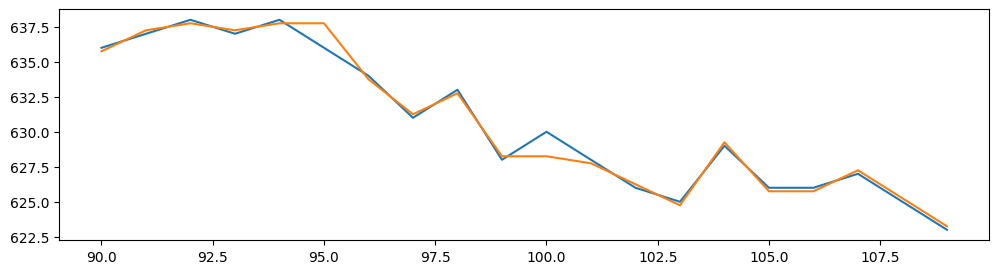

In [138]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'].iloc[90:110])
plt.plot((observations['bidPrice'][90:110] + observations['askPrice'])[90:110] / 2)
plt.show()

In [141]:
np.log(prices['mid_price'] / prices['mid_price'].shift(1)).dropna().std()

np.float64(0.003942451119845575)

In [145]:
np.log(((observations['bidPrice'] + observations['askPrice']) / 2) / ((observations['bidPrice'] + observations['askPrice']) / 2).shift(1)).dropna().std()

np.float64(0.0037287431676968274)

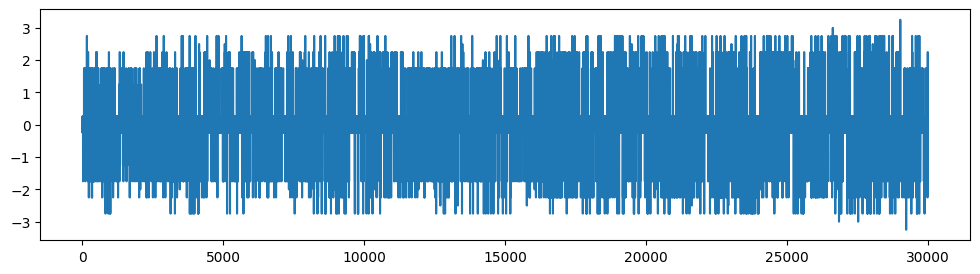

In [134]:
plt.figure(figsize=(12, 3))
plt.plot((observations['bidPrice'] + observations['askPrice']) / 2 - prices['mid_price'])
plt.show()

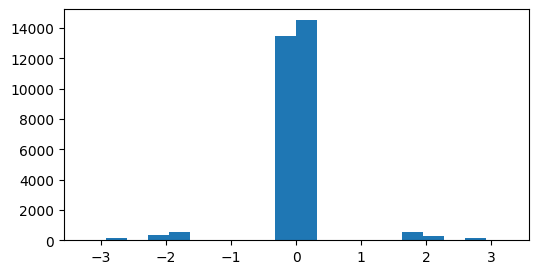

In [149]:
plt.figure(figsize=(6, 3))
plt.hist((observations['bidPrice'] + observations['askPrice']) / 2 - prices['mid_price'], bins=20)
plt.show()

## Price prediction - popular mid price

In [150]:
lags = range(-1000, 1001)

In [151]:
corrs_sugar = []
for lag in lags:
    if lag > 0:
        corrs_sugar.append(np.corrcoef(prices['mid_price'][lag:], observations['sugarPrice'][:-lag])[0, 1])
    elif lag < 0:
        corrs_sugar.append(np.corrcoef(observations['sugarPrice'][-lag:], prices['mid_price'][:lag])[0, 1])
    else:
        corrs_sugar.append(np.corrcoef(prices['mid_price'], observations['sugarPrice'])[0, 1])

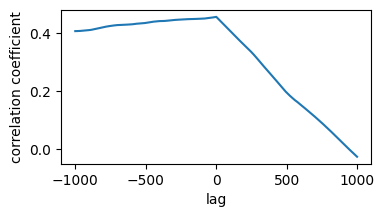

In [152]:
plt.figure(figsize=(4, 2))
plt.plot(lags, corrs_sugar)
plt.xlabel('lag')
plt.ylabel('correlation coefficient')
plt.show()

In [153]:
corrs_sun = []
for lag in lags:
    if lag > 0:
        corrs_sun.append(np.corrcoef(prices['mid_price'][lag:], observations['sunlightIndex'][:-lag])[0, 1])
    elif lag < 0:
        corrs_sun.append(np.corrcoef(observations['sunlightIndex'][-lag:], prices['mid_price'][:lag])[0, 1])
    else:
        corrs_sun.append(np.corrcoef(prices['mid_price'], observations['sunlightIndex'])[0, 1])

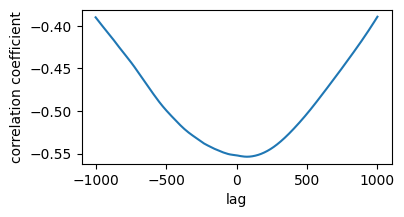

In [154]:
plt.figure(figsize=(4, 2))
plt.plot(lags, corrs_sun)
plt.xlabel('lag')
plt.ylabel('correlation coefficient')
plt.show()

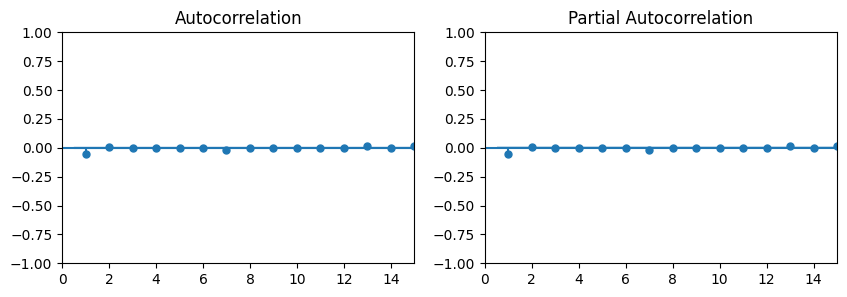

In [156]:
logr = np.log(prices['mid_price'] / prices['mid_price'].shift(1)).dropna()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(logr, ax=ax[0], zero=False)
plot_pacf(logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

In [206]:
x = observations[['sugarPrice', 'sunlightIndex']].iloc[:-1].reset_index(drop=True)
x['macaronPrice'] = prices['mid_price'].iloc[:-1].reset_index(drop=True)
x = x.to_numpy()
x = np.log(x[1:, :] / x[:-1, :])

y = prices['mid_price'].iloc[1:].to_numpy()
y = np.log(y[1:] / y[:-1])

### Naive

In [212]:
err = y[10000:]
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 0.0039840988804826965


### Linear regression - One feature

In [213]:
model = LinearRegression()
model.fit(np.expand_dims(x[:10000, 2], axis=-1), y[:10000])

LinearRegression()

In [214]:
model.coef_

array([-0.04482184])

In [215]:
pred = model.predict(np.expand_dims(x[10000:, 2], axis=-1))
err = y[10000:] - pred
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 0.003977342275989989


### Linear Regression - Three features

In [216]:
model = LinearRegression()
model.fit(x[:10000, :], y[:10000])

LinearRegression()

In [217]:
model.coef_

array([ 0.25249905, -0.17120604, -0.07990168])

In [218]:
pred = model.predict(x[10000:])

In [219]:
err = y[10000:] - pred
print(f'RMSE: {np.sqrt(np.mean(err ** 2))}')

RMSE: 0.0039739553371184655
